### Домашнее задание. Определение ССЗ

ссылка на соревнование - https://mlbootcamp.ru/ru/round/12/sandbox/

В рамках конкурса вам нужно предсказать наличие сердечно-сосудистых заболеваний по результатам классического врачебного осмотра. Датасет сформирован из 100.000 реальных клинических анализов, и в нём используются признаки, которые можно разбить на 3 группы:

 

Объективные признаки:

 - Возраст
 - Рост
 - Вес
 - Пол
 

Результаты измерения:

 - Артериальное давление верхнее и нижнее
 - Холестерин
 - Глюкоза
 

Субъективные признаки:

 - Курение
 - Употребление Алкоголя
 - Физическая активность
 

Возраст дан в днях. Значения показателей холестерина и глюкозы представлены одним из трех классов: норма, выше нормы, значительно выше нормы. Значения субъективных признаков — бинарны.

Все показатели даны на момент осмотра.

Таргет - наличие сердечно-сосудистых заболеваний (ССЗ)

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import cross_val_score, train_test_split

In [2]:
df = pd.read_csv('./train_case2.csv', sep=';')
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


Разделим наши данные на тренировочную и тестовую выборки

In [3]:
df['cardio'].value_counts()

cardio
0    35021
1    34979
Name: count, dtype: int64

In [4]:
#разделим данные на train/test
X = df.drop('cardio', axis=1)
y = df['cardio']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7,
                                                    random_state=42)

In [5]:
X_train.shape

(49000, 12)

In [6]:
y_train.value_counts(normalize=True)

cardio
0    0.501224
1    0.498776
Name: proportion, dtype: float64

In [7]:
y_test.value_counts(normalize=True)

cardio
1    0.501857
0    0.498143
Name: proportion, dtype: float64

К полям:
- gender, cholesterol применим OHE-кодирование
- age, height, weight, ap_hi, ap_lo - standardScaler
- gluc, smoke, alco, active - оставим пока как есть

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin

In [9]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]

In [10]:
from sklearn.pipeline import Pipeline

In [11]:
from sklearn.preprocessing import StandardScaler


continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

Теперь объединим все наши трансформеры с помощью FeatureUnion

In [12]:
from sklearn.pipeline import FeatureUnion

In [13]:
feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[ 0.38817489, -0.5308834 , -0.70816849, ...,  0.        ,
         0.        ,  1.        ],
       [ 1.30846829,  0.32314728, -0.63861364, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.34652706, -0.5308834 , -0.56905879, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.67245587,  0.56715605, -0.01261999, ...,  0.        ,
         0.        ,  1.        ],
       [-0.49851342,  0.32314728, -0.29083939, ...,  0.        ,
         0.        ,  0.        ],
       [-1.75890645,  1.54319112, -0.70816849, ...,  0.        ,
         0.        ,  1.        ]])

Добавим классификатор и запустим кросс-валидацию

In [14]:
from sklearn.linear_model import LogisticRegression

In [15]:
%%time

classifier = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(C=10, random_state = 42)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=5, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
lr_y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.7804104614371699+-0.002237706961468122
CPU times: total: 3.48 s
Wall time: 936 ms


Посчитаем precision/recall/f_score

In [16]:
from sklearn.metrics import precision_recall_curve

In [17]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, lr_y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
lr_scr = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[lr_scr], 
                                                                        fscore[lr_scr],
                                                                        precision[lr_scr],
                                                                        recall[lr_scr]))

Best Threshold=0.409051, F-Score=0.734, Precision=0.662, Recall=0.824


Нарисуем roc auc кривую

In [18]:
from sklearn.metrics import roc_curve

import seaborn as sns
import itertools
import matplotlib.pyplot as plt

%matplotlib inline

In [19]:
def make_roc_curve(y_test, y_score):
    sns.set(font_scale=1.5)
    sns.set_color_codes("muted")

    plt.figure(figsize=(10, 8))
    fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
    lw = 2
    plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.savefig("ROC.png")
    plt.show()

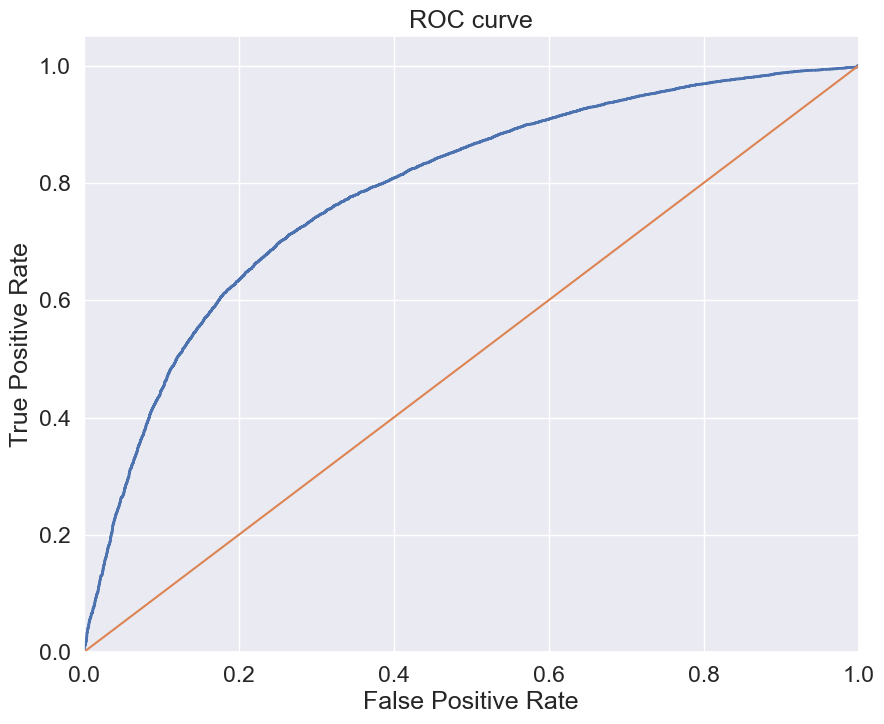

In [20]:
make_roc_curve(y_test, lr_y_score)

In [21]:
from sklearn.metrics import roc_auc_score, log_loss

In [22]:
#Ваш код здесь
lr_roc_auc_score=roc_auc_score(y_true=y_test, y_score=lr_y_score)
lr_log_loss=log_loss(y_true=y_test, y_pred=lr_y_score)

print("lr roc auc score: {}".format(lr_roc_auc_score))
print("lr log loss score: {}".format(lr_log_loss))

lr roc auc score: 0.7854397927793635
lr log loss score: 0.5749519394327656


Посомтрим на матрицу ошибок

In [23]:
from sklearn.metrics import confusion_matrix

In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [25]:
def make_cnf_mtx(y_test, y_score, scr):
    font = {'size' : 15}

    plt.rc('font', **font)

    cnf_matrix = confusion_matrix(y_test, y_score>thresholds[scr])
    plt.figure(figsize=(10, 8))
    plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                          title='Confusion matrix')
    plt.savefig("conf_matrix.png")
    plt.show()
    
    return cnf_matrix

Confusion matrix, without normalization
[[6035 4426]
 [1856 8683]]


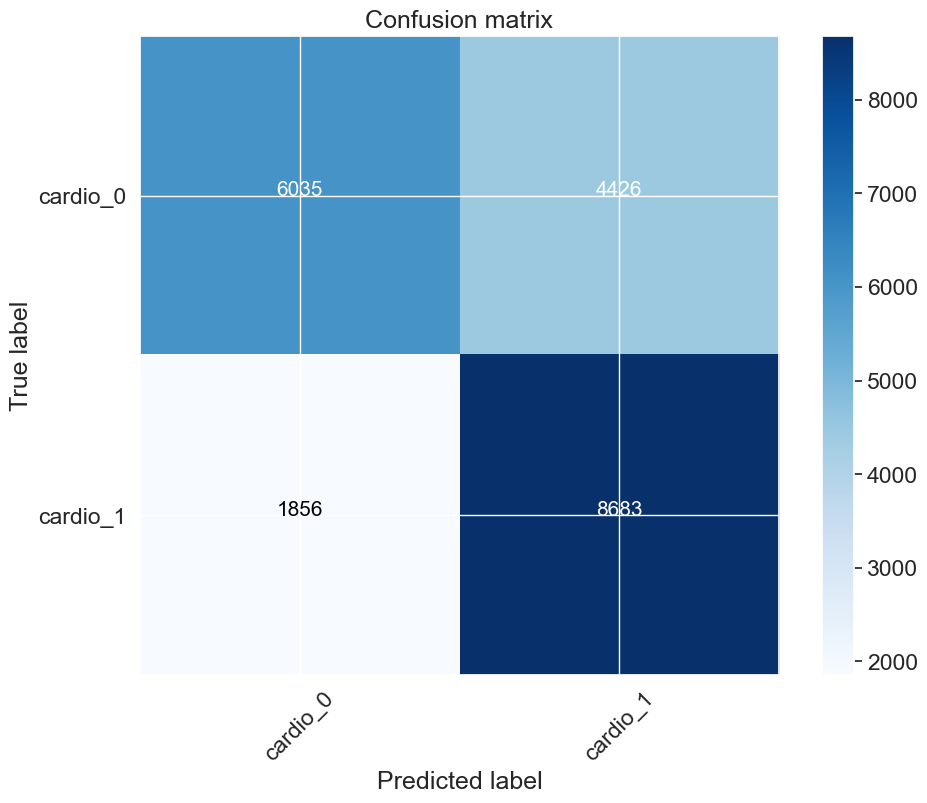

In [26]:
lr_cnf_matrix = make_cnf_mtx(y_test, lr_y_score, lr_scr)

Посчитаем FPR, TPR

In [27]:
def make_FPR_TPR(cnf_matrix):
    TN = cnf_matrix[0][0]
    FN = cnf_matrix[1][0]
    TP = cnf_matrix[1][1]
    FP = cnf_matrix[0][1]

    TPR = TP/(TP+FN)
    FPR = FP/(FP+TN)
    TNR = TN/(FP+TN)
    return TPR, FPR, TNR

In [28]:
make_FPR_TPR(lr_cnf_matrix)

(0.8238922098870861, 0.42309530637606346, 0.5769046936239365)

False Positive Rate довольно высокий ~ 0.42.

Это означает, что 42 процентов всех пациентов получат метку 1 при том, что они на самом деле здоровы

Хорошая ли модель у нас получилась? - ответ сильно зависит от внешних факторов (какое количество FP мы можем допустить)

### Модель Градиентного бустинга

In [29]:
from sklearn.ensemble import GradientBoostingRegressor

In [30]:
params = {'n_estimators':100,
          'max_depth':4,
          'criterion':'squared_error',
          'learning_rate':0.03,
          'min_samples_leaf':10,
          'min_samples_split':10
          }

In [31]:
%%time

classifier = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingRegressor(**params)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=5, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
gbr_y_score = classifier.predict(X_test)

CV score is 0.7997364937681605+-0.004084462301112094
CPU times: total: 34.2 s
Wall time: 34.3 s


Посчитаем precision/recall/f_score

In [32]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, gbr_y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
gbr_scr = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[gbr_scr], 
                                                                        fscore[gbr_scr],
                                                                        precision[gbr_scr],
                                                                        recall[gbr_scr]))

Best Threshold=0.405383, F-Score=0.745, Precision=0.703, Recall=0.793


Нарисуем roc auc кривую

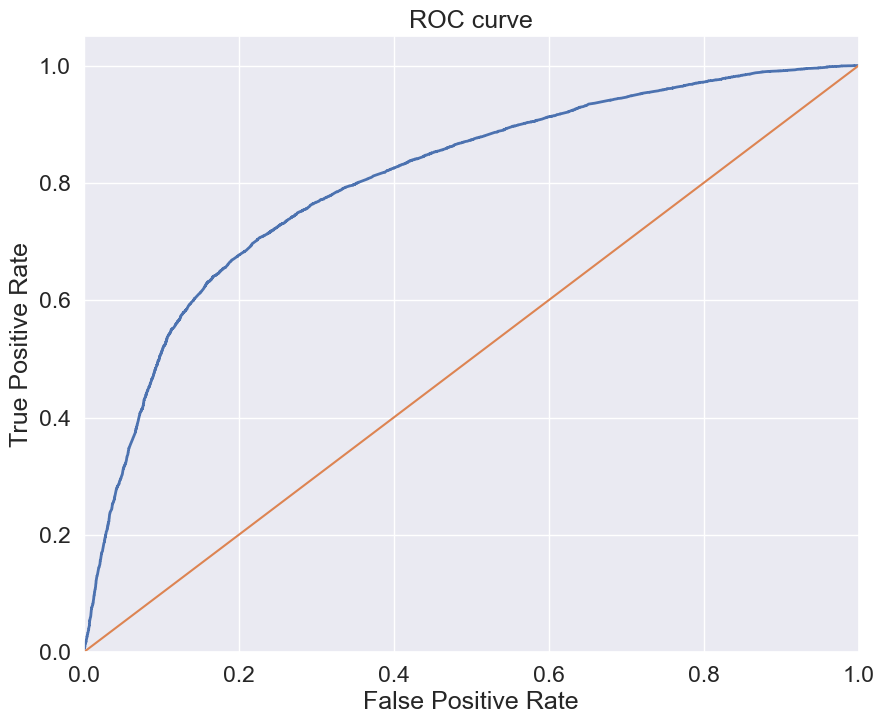

In [33]:
make_roc_curve(y_test, gbr_y_score)

In [34]:
#Ваш код здесь
gbr_roc_auc_score=roc_auc_score(y_true=y_test, y_score=gbr_y_score)
gbr_log_loss=log_loss(y_true=y_test, y_pred=gbr_y_score)

print("lr roc auc score: {}".format(gbr_roc_auc_score))
print("lr log loss score: {}".format(gbr_log_loss))

lr roc auc score: 0.8033754687899142
lr log loss score: 0.5407664967794791


Посомтрим на матрицу ошибок

Confusion matrix, without normalization
[[6926 3535]
 [2186 8353]]


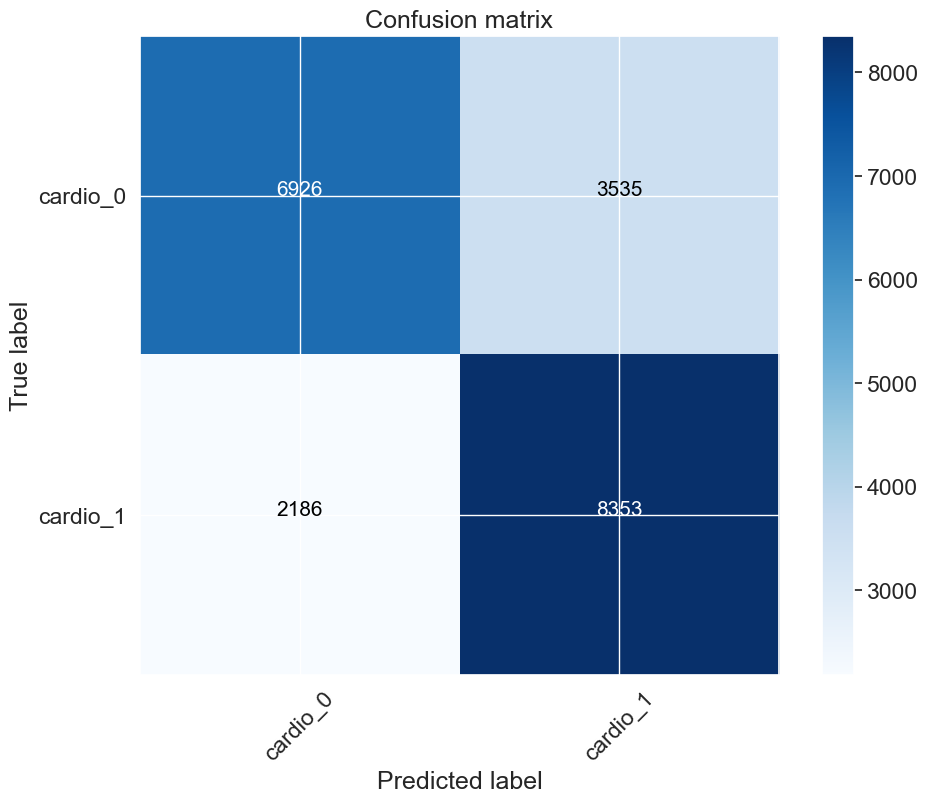

In [35]:
gbr_cnf_matrix = make_cnf_mtx(y_test, gbr_y_score, gbr_scr)

Посчитаем FPR, TPR

In [36]:
make_FPR_TPR(gbr_cnf_matrix)

(0.792579941170889, 0.3379218047987764, 0.6620781952012236)

False Positive Rate ниже чем в модели логистической регрессии ~ 0.34.

Это означает, что 34 процентов всех пациентов получат метку 1 при том, что они на самом деле здоровы

### Модель Случайного леса

In [40]:
from sklearn.ensemble import RandomForestClassifier

In [41]:
%%time

classifier = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier()),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=5, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
rfc_y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.7731869778810836+-0.0027339225939413984
CPU times: total: 58.1 s
Wall time: 58.1 s


Посчитаем precision/recall/f_score

In [42]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, rfc_y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
rfc_scr = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[rfc_scr], 
                                                                        fscore[rfc_scr],
                                                                        precision[rfc_scr],
                                                                        recall[rfc_scr]))

Best Threshold=0.340000, F-Score=0.724, Precision=0.639, Recall=0.834


Нарисуем roc auc кривую

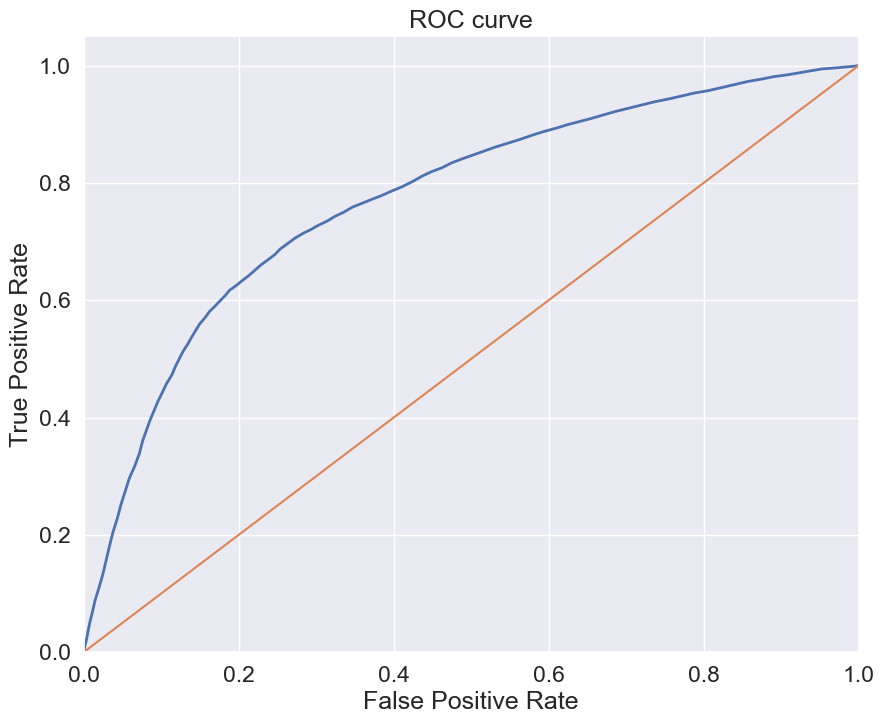

In [43]:
make_roc_curve(y_test, rfc_y_score)

In [44]:
#Ваш код здесь
rfc_roc_auc_score=roc_auc_score(y_true=y_test, y_score=rfc_y_score)
rfc_log_loss=log_loss(y_true=y_test, y_pred=rfc_y_score)

print("lr roc auc score: {}".format(rfc_roc_auc_score))
print("lr log loss score: {}".format(rfc_log_loss))

lr roc auc score: 0.7732672030786022
lr log loss score: 0.6082712677582037


Посомтрим на матрицу ошибок

Confusion matrix, without normalization
[[5625 4836]
 [1836 8703]]


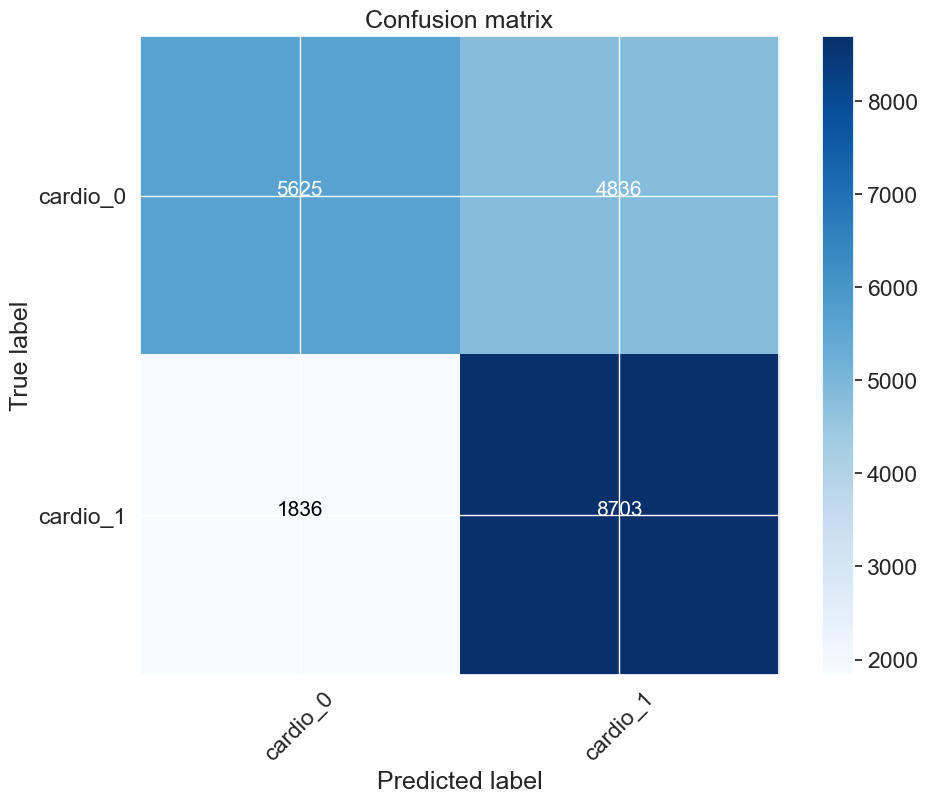

In [45]:
rfc_cnf_matrix = make_cnf_mtx(y_test, rfc_y_score, rfc_scr)

Посчитаем FPR, TPR

In [46]:
make_FPR_TPR(rfc_cnf_matrix)

(0.8257899231426131, 0.46228850014338974, 0.5377114998566103)

False Positive Rate самый высокий ~ 0.46.

Это означает, что 46 процентов всех пациентов получат метку 1 при том, что они на самом деле здоровы

Модель градиентного бустинга справилась с задачей лучше всех.

### Домашнее задание

1. обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта
2. при обучении моделей обязательно использовать кроссвалидацию
3. вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)
4. сделать выводы о том, какая модель справилась с задачей лучше других
5. (опциональный вопрос) какая метрика (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого). 

p.s.В вопросе проще разобраться, если вспомнить оси на графике roc auc curve и рассмотреть такой пример:

Имеется 100000 объектов, из которых только 100 - класс "1" (99900 - класс "0", соответственно). 
Допустим, у нас две модели:

- первая помечает 100 объектов как класс 1, но TP = 90
- вторая помечает 1000 объектов как класс 1, но TP такой же - 90

Какая модель лучше и почему? И что позволяет легче сделать вывод - roc_auc_curve или precision_recall_curve?

### Ссылки

1. https://dyakonov.org/2017/07/28/auc-roc-площадь-под-кривой-ошибок/
2. https://en.wikipedia.org/wiki/Receiver_operating_characteristic